In [2]:
%pip install plotly

In [2]:
import pandas as pd

bookings = pd.read_csv('../raw-data/booking/bookings.csv')

### Fix typings
TODO: move to the scraper itself

In [3]:
bookings['number_of_reviews'] = bookings['number_of_reviews'].str.replace(',', '', regex=True)
bookings['number_of_reviews'] = pd.to_numeric(bookings['number_of_reviews'], errors='coerce')
bookings['review_score'] = pd.to_numeric(bookings['review_score'], errors='coerce')
bookings['original_price'] = pd.to_numeric(bookings['original_price'], errors='coerce')
bookings['discounted_price'] = pd.to_numeric(bookings['discounted_price'], errors='coerce')

In [4]:
bookings['discount'] = bookings['discount'].apply(lambda x: 1 if x == 'True' else 0)
bookings['breakfast_included'] = bookings['breakfast_included'].apply(lambda x: 1 if x == 'True' else 0)
bookings['free_cancellation'] = bookings['free_cancellation'].apply(lambda x: 1 if x == 'True' else 0)
bookings['prepayment_needed'] = bookings['prepayment_needed'].apply(lambda x: 1 if x == 'True' else 0)
bookings['is_apartment'] = bookings['is_apartment'].apply(lambda x: 1 if x == 'True' else 0)
bookings.fillna(bookings['review_score'].min(), inplace=True)

### Reviews Distribution
Group the review counts by snapshot dates, and the names of the hotels. the `number_of_reviews` will be a the same for the same hotel in a certain snapshot.   

In [5]:
number_of_reviews = bookings.groupby(['name', 'snapshot_date'], as_index=False)['number_of_reviews'].first()
number_of_reviews

,name,snapshot_date,number_of_reviews
0,1 Hotel Central Park,2025-02-02,556.0
1,1 Hotel Central Park,2025-02-03,556.0
2,1 Hotel Central Park,2025-02-04,555.0
3,17John,2025-02-02,209.0
4,17John,2025-02-03,209.0
...,...,...,...
1068,"voco The Franklin New York, an IHG Hotel",2025-02-02,508.0
1069,"voco The Franklin New York, an IHG Hotel",2025-02-03,508.0
1070,"voco Times Square South New York, an IHG Hotel",2025-02-02,3803.0
1071,"voco Times Square South New York, an IHG Hotel",2025-02-03,3806.0


In [6]:
snapshot_dates = bookings['snapshot_date'].unique()

In [7]:
import plotly.graph_objects as go

fig = go.Figure()

for date in snapshot_dates:
    data = number_of_reviews[number_of_reviews['snapshot_date'] == date]['number_of_reviews'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, autobinx=True))

# Update layout for better visualization
fig.update_layout(
    title= "Distribution of Number of Reviews for Each Snapshot Date",
    xaxis_title="Number of Reviews",
    yaxis_title="Frequency",
    barmode="overlay",  # Makes histograms overlap
    legend_title="Snapshot Date",
    width=1400,  # Increase figure width
    height=800   # Increase figure height
)

# Show interactive plot
fig.show()

The histogram above shows a right-skewed distribution of the number of reviews, where lower review counts appear with higher frequency. This suggests a heavy-tailed distribution, meaning that while most hotels have relatively few reviews, a small number of hotels have significantly higher review counts.

In [8]:
review_scores = bookings.groupby(['name', 'snapshot_date'], as_index=False)['review_score'].first()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    data = review_scores[review_scores['snapshot_date'] == date]['review_score'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, bingroup=100))

# Update layout to separate the graphs
fig.update_layout(
    title="Distribution of Review Scores for Each Snapshot Date",
    xaxis_title="Review Score",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms are separate
    legend_title="Snapshot Date",
    width=1000,
    height=600
)

# Show interactive plot
fig.show()

The histogram shows that most hotel review scores fall between **7 and 9**, with a peak around **8**, indicating generally positive experiences. Scores below **5** are rare to none.  

The similarity between the snapshot dates suggests that hotel ratings remain stable over time. While a few hotels receive low scores (**1-4**), these are outliers rather than the norm.  

The data above shows that **Booking.com prioritizes highly rated hotels** in its listings. Among the 100 hotels that appeared in each search, none have a review score below **6**, indicating that poorly rated hotels are likely filtered out. This aligns with Booking.com’s strategy of promoting well-reviewed properties to enhance user experience, while "punishing" lesser options.  

In [9]:
price_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price', 'discounted_price']].first()

# Get unique snapshot dates
snapshot_dates = price_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_data[price_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price'].dropna(),
        name=f"Original Price - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price'].dropna(),
        name=f"Discounted Price - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices for Each Snapshot Date",
    xaxis_title="Price",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

The prices shown in the graph above do not account for the length of stay. The graph below displays the distribution of "price per night."

In [10]:
bookings['discounted_price_per_night'] = bookings['discounted_price'] / bookings['length_of_stay']
bookings['original_price_per_night'] = bookings['original_price'] / bookings['length_of_stay']

price_per_night_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price_per_night', 'discounted_price_per_night']].first()

# Get unique snapshot dates
snapshot_dates = price_per_night_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_per_night_data[price_per_night_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price_per_night'].dropna(),
        name=f"Original Price per night - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price_per_night'].dropna(),
        name=f"Discounted Price per night - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices per night for Each Snapshot Date",
    xaxis_title="Price per night",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

The plot above reveals a **wide range** of hotel prices, extending beyond **$3000 per night**, indicating the presence of high-end luxury hotels. However, when focusing on the **main distribution**—excluding extreme outliers—it becomes clear that most hotels are priced **below $500 per night**, with a peak around **$150-$300**. This suggests that while premium listings exist, Booking.com primarily features mid-range accommodations.  

### Filter outliers by price per night data

In [11]:
import plotly.express as px

# Create a box plot (hbox) for original and discounted price per night
fig = px.box(
    price_per_night_data.melt(id_vars=['snapshot_date'], value_vars=['original_price_per_night', 'discounted_price_per_night'], 
                              var_name="Price Type", value_name="Price per Night"),
    x="snapshot_date",
    y="Price per Night",
    color="Price Type",
    title="Box Plot of Original and Discounted Prices per Night for Each Snapshot Date",
    labels={"snapshot_date": "Snapshot Date", "Price per Night": "Price per Night"},
    width=1000,
    height=600
)

# Show the interactive box plot
fig.show()

The **matching upper and lower fences for Feb 2** indicate that the interquartile range (IQR) and whiskers are exactly the same for both original and discounted prices.
The hotels that appear in the first 100 searches mostly (bounded by the upper and lower fences) are in the range of 86$ per night and 470$ per night.  

**Key observation**: 
The site suggest discounts when the original price does not fall in the IQR. The prices shown all fall in the same price range


In [12]:
# Remove price outliers using Tukey's IQR method
new_bookings = bookings.copy()
Q1 = new_bookings["original_price_per_night"].quantile(0.25)
Q3 = new_bookings["original_price_per_night"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset
new_bookings = new_bookings[(new_bookings["original_price_per_night"] >= lower_bound) & (new_bookings["original_price_per_night"] <= upper_bound)]

# Drop bookings without review title
new_bookings = new_bookings.dropna(subset=['review_title'])

# Display the number of rows after filtering
print(f"Rows after filtering: {len(new_bookings)}, Rows before filtering: {len(bookings)}")

Rows after filtering: 43694, Rows before filtering: 44998


In [13]:
new_bookings['review_title'].unique()

array(['Very good', 'Good', 'Fabulous', 'Review score', 'Superb',
       'Exceptional', 1.0], dtype=object)

In [14]:
# Define ordinal mappings for review titles
review_title_mapping = {
    'Review score': 1,   # Lowest
    'Good': 2,
    'Very good': 3,
    'Fabulous': 4,
    'Superb': 5,
    'Exceptional': 6    # Highest
}

# Apply the mapping to review_title column
new_bookings["review_title_rank"] = new_bookings["review_title"].map(review_title_mapping)

In [15]:
# Extract unique bed types
unique_beds = bookings["bed_type"].dropna().unique()
unique_beds

array(['1 large double bed', '1 extra-large double bed', '1 double bed',
       '1 single bed', '2 single beds', '2 double beds',
       '2 large double beds', 1.0, 'Multiple bed types', '1 bunk bed',
       'Private suite', '3 beds (2 doubles, 1 sofa bed)',
       '2 beds (1 extra-large double, 1 sofa bed)',
       '2 extra-large double beds', '2 beds (1 bunk bed, 1 large double)',
       '2 bunk beds', '2 beds (1 double, 1 sofa bed)',
       '5 beds (3 extra-large doubles, 2 large doubles)',
       '2 beds (1 single, 1 extra-large double)', '3 single beds',
       '2 beds (1 single, 1 large double)', '2 beds (1 single, 1 double)',
       'Beds: 1 double or 2 singles',
       '2 beds (1 sofa bed, 1 large double)',
       '4 beds (1 double, 1 bunk bed, 1 sofa bed, 1 large double)',
       '3 beds (1 bunk bed, 2 large doubles)',
       '4 beds (1 bunk bed, 3 large doubles)'], dtype=object)

In [16]:
# Example ranking for bed types (adjust as needed)
bed_type_mapping = {
    'Multiple bed types': 1,  # Vague and lacks specifics
    '1 single bed': 2,  # Least valuable, smallest sleeping arrangement
    '1 bunk bed': 3,  # Compact but only good for certain situations
    '1 double bed': 4,  # Standard, but smaller than a large double
    '1 large double bed': 5,  # Comfortable for two
    '1 extra-large double bed': 6,  # Large and luxurious for two
    '2 single beds': 7,  # Simple twin setup, less desirable than a double
    '2 bunk beds': 8,  # Sleeps four but is less comfortable
    '3 single beds': 9,  # Good for separate sleepers but lacks bed size variety
    '2 beds (1 single, 1 double)': 10,  # One double and one single, still decent
    '2 beds (1 single, 1 large double)': 11,  # One large and one single, slightly less valuable than extra-large
    '2 beds (1 single, 1 extra-large double)': 12,  # One very large and one small bed
    '2 beds (1 bunk bed, 1 large double)': 13,  # One solid large bed + bunk bed for kids
    '2 beds (1 sofa bed, 1 large double)': 14,  # Large double + extra seating/bed
    '2 beds (1 double, 1 sofa bed)': 15,  # Standard double bed + sofa, good for a couple + 1
    '2 beds (1 extra-large double, 1 sofa bed)': 16,  # Large main bed + extra sofa sleeper
    'Beds: 1 double or 2 singles': 17,  # Flexibility makes this valuable
    '2 double beds': 18,  # Standard two-bed setup, good for small families/groups
    '2 large double beds': 19,  # Large but slightly less spacious than extra-large beds
    '2 extra-large double beds': 20,  # Luxury and spacious for up to four people
    '3 beds (2 doubles, 1 sofa bed)': 21,  # Two doubles + a sofa bed is a flexible setup
    '3 beds (1 bunk bed, 2 large doubles)': 22,  # Large family/group-friendly
    '4 beds (1 double, 1 bunk bed, 1 sofa bed, 1 large double)': 23,  # Great for a mix of sleepers
    '5 beds (3 extra-large doubles, 2 large doubles)': 24,  # Accommodates large groups comfortably
    'Private suite': 25  # Typically premium, offering the best experience
}

# Apply bed type ranking
new_bookings["bed_type_rank"] = new_bookings["bed_type"].map(bed_type_mapping)

# Show a preview of the transformed columns
new_bookings[["review_title", "review_title_rank", "bed_type", "bed_type_rank"]].head()

,review_title,review_title_rank,bed_type,bed_type_rank
0,Very good,3.0,1 large double bed,5.0
1,Good,2.0,1 extra-large double bed,6.0
2,Fabulous,4.0,1 double bed,4.0
3,Good,2.0,1 single bed,2.0
4,Good,2.0,1 extra-large double bed,6.0


In [17]:
new_bookings['neighborhood'].unique()

array(['Manhattan, New York', "Hell's Kitchen, New York",
       'Upper West Side, New York', 'Chelsea, New York',
       'Lower East Side, New York', 'SoHo, New York',
       'Midtown East, New York', 'Tribeca, New York',
       'Gramercy, New York', 'Murray Hill, New York',
       'Chinatown, New York', 'Upper East Side, New York',
       'NoMad, New York', 'Flatiron District, New York',
       'Washington Heights, New York', 'Little Italy, New York',
       'Kips Bay, New York', 'Harlem, New York', 'New York',
       'Greenwich Village, New York', 'Hudson Yards, New York',
       'Union Square, New York', 'East Village, New York',
       'Battery Park, New York', 'East Harlem, New York'], dtype=object)

In [18]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop="first", sparse_output=False)  

# Fit and transform the data
encoded_data = encoder.fit_transform(new_bookings[["neighborhood"]])
encoded_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

one hot encoded neighborhood dataframe:

In [19]:
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['neighborhood']))
encoded_df.columns = [col.replace(", New York", "").strip() for col in encoded_df.columns]

encoded_df

,neighborhood_Chelsea,neighborhood_Chinatown,neighborhood_East Harlem,neighborhood_East Village,neighborhood_Flatiron District,neighborhood_Gramercy,neighborhood_Greenwich Village,neighborhood_Harlem,neighborhood_Hell's Kitchen,neighborhood_Hudson Yards,...,neighborhood_Midtown East,neighborhood_Murray Hill,neighborhood_New York,neighborhood_NoMad,neighborhood_SoHo,neighborhood_Tribeca,neighborhood_Union Square,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Combine the dataframes

In [20]:
encoded_df = encoded_df.reset_index(drop=True)
new_bookings = new_bookings.reset_index(drop=True)

# Concatenate along columns
new_bookings = pd.concat([new_bookings, encoded_df], axis=1)
new_bookings

,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,is_apartment,...,neighborhood_Midtown East,neighborhood_Murray Hill,neighborhood_New York,neighborhood_NoMad,neighborhood_SoHo,neighborhood_Tribeca,neighborhood_Union Square,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights
0,0,Iroquois New York Times Square,292,218,0,8.5,Very good,2625.0,5.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Four Points by Sheraton New York Downtown,130,111,0,7.8,Good,1987.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"The Mayfair Hotel Times Square, Ascend Hotel C...",141,141,0,8.6,Fabulous,1895.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,The Washington by LuxUrban,160,160,0,7.7,Good,9442.0,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Hampton Inn by Hilton New York Times Square,152,152,0,7.8,Good,2432.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43689,44992,Hampton Inn Manhattan-35th St Empire State Bldg,1207,1207,0,8.2,Very good,6701.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43690,44994,Renaissance New York Midtown Hotel,1896,1521,0,8.7,Fabulous,1601.0,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43691,44995,"Hotel Indigo NYC Financial District, an IHG Hotel",1047,1047,0,8.9,Fabulous,1548.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43692,44996,Hilton Garden Inn NYC Financial Center/Manhatt...,999,999,0,8.3,Very good,5048.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


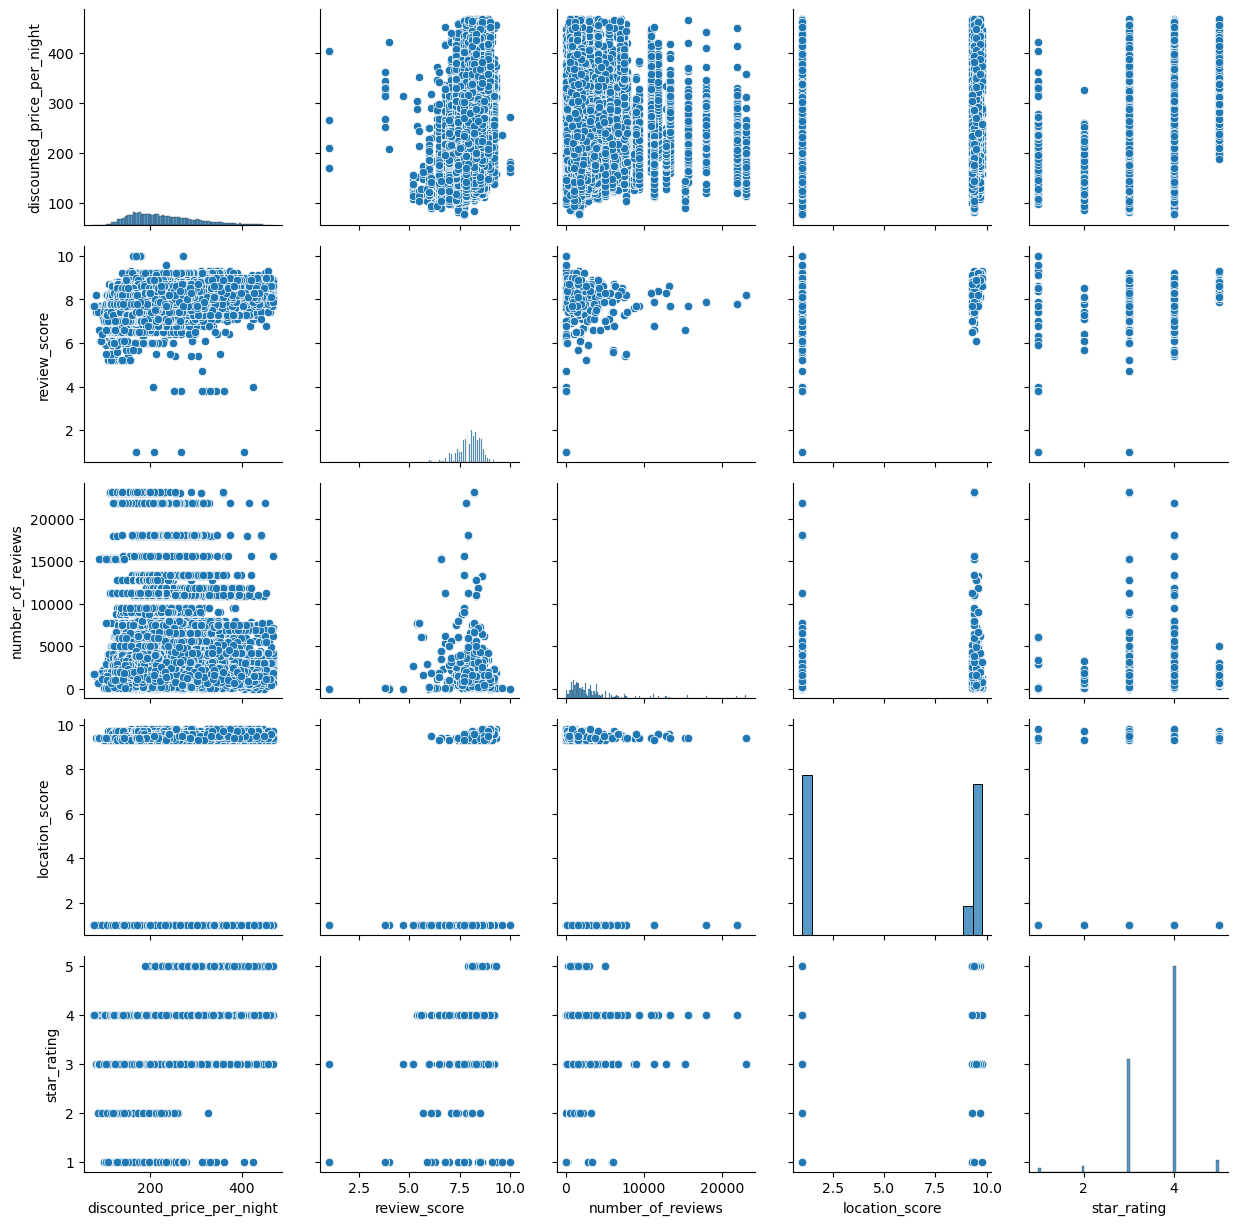

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical variables for PairGrid
selected_columns = ["discounted_price_per_night", "review_score", "number_of_reviews", "location_score", "star_rating"]
pairgrid_df = new_bookings[selected_columns].dropna()  # Drop NaN values for plotting

# Create PairGrid
g = sns.PairGrid(pairgrid_df)
g.map_diag(sns.histplot)  # Histograms on the diagonal
g.map_offdiag(sns.scatterplot)  # Scatter plots on off-diagonal

# Show the plot
plt.show()

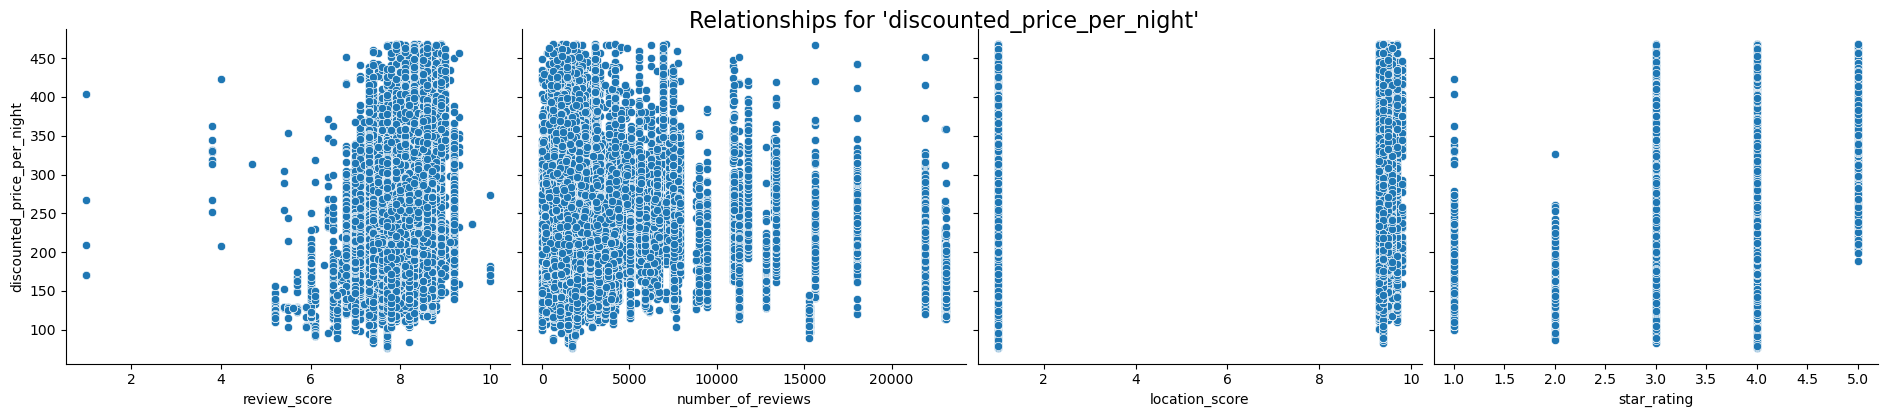

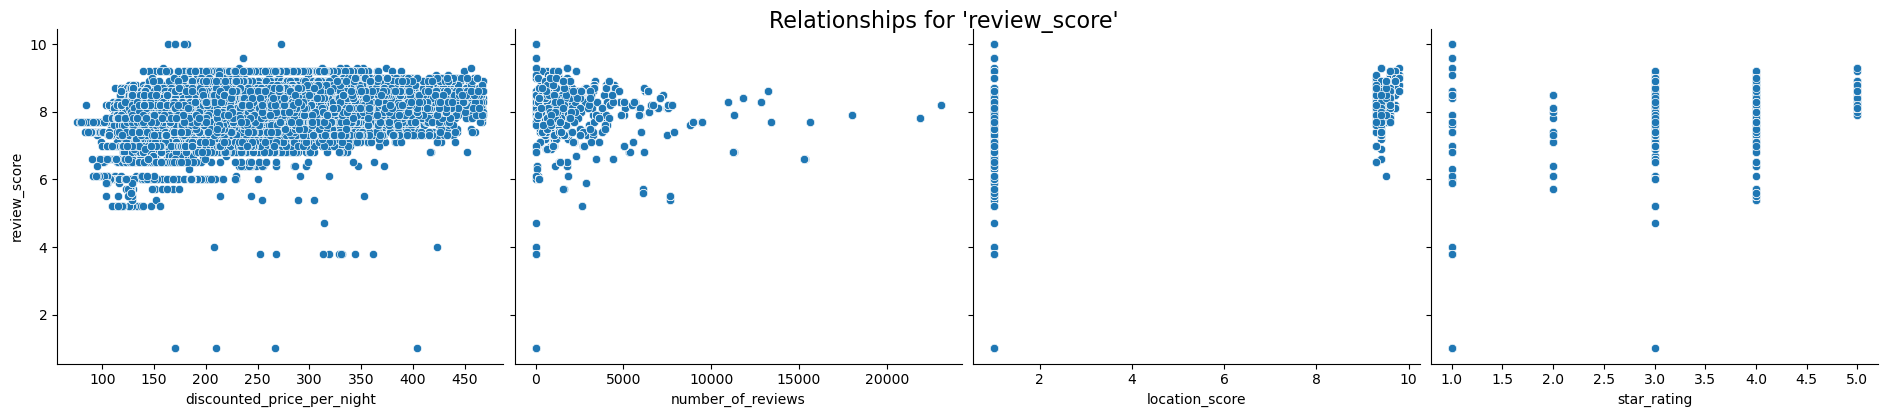

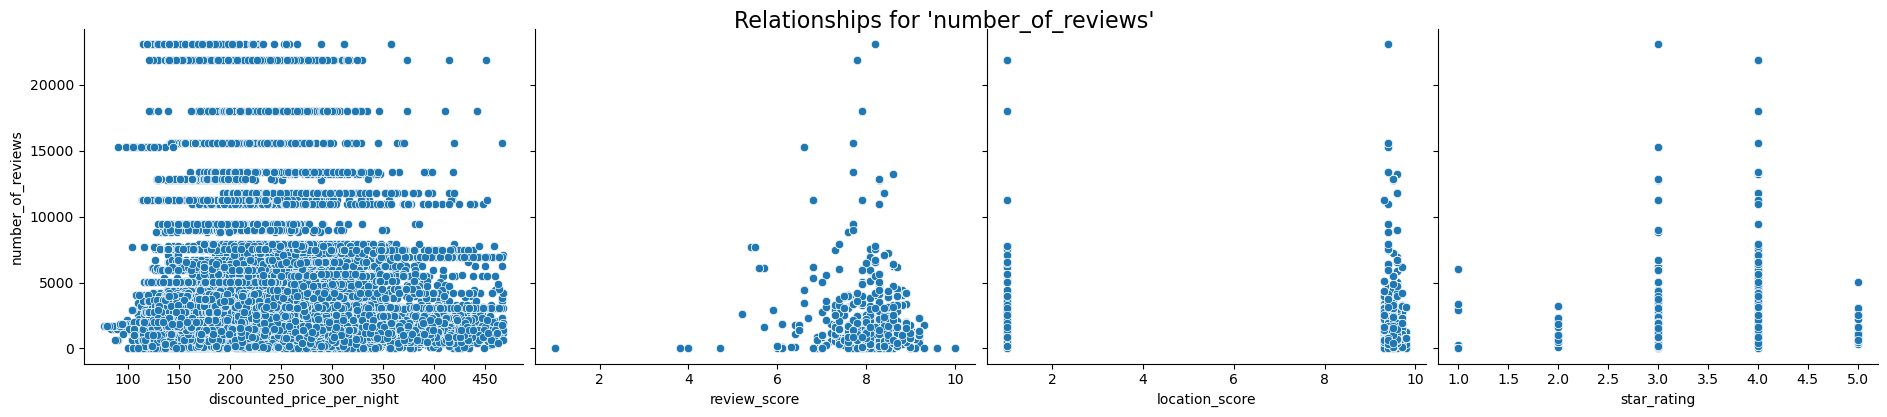

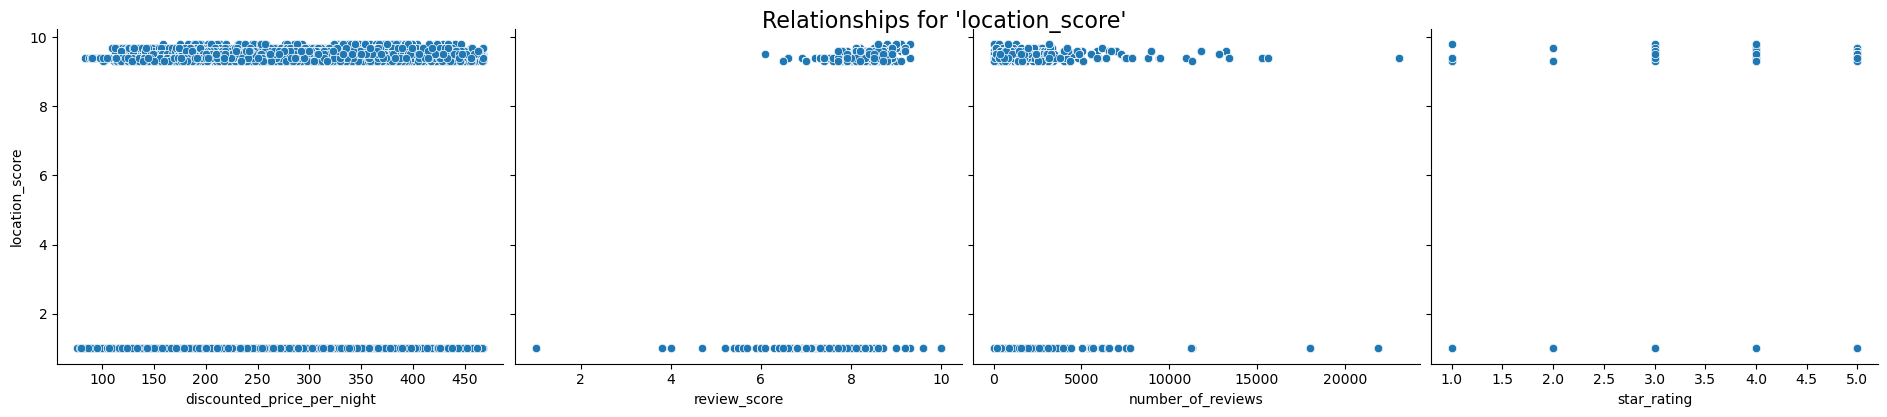

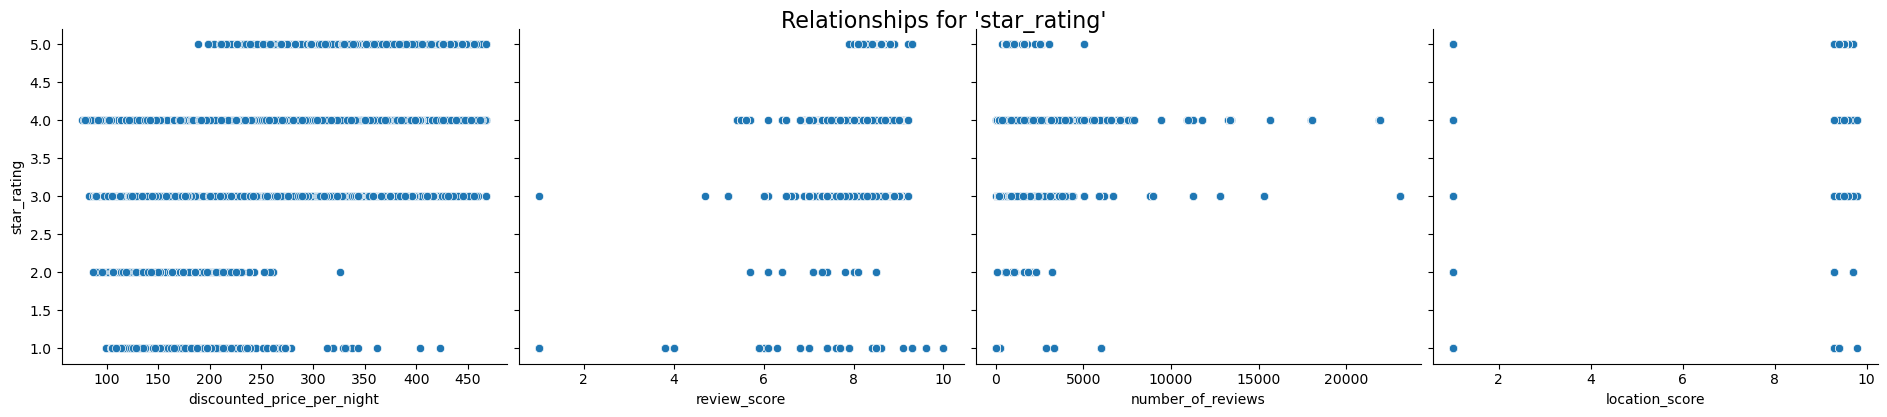

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selected numerical columns
selected_columns = ["discounted_price_per_night", "review_score", "number_of_reviews", "location_score", "star_rating"]

# Drop NaN values
pairgrid_df = new_bookings[selected_columns].dropna()

# Plot each row individually (one variable against others)
for col in selected_columns:
    sns.pairplot(pairgrid_df, 
                 x_vars=[c for c in selected_columns if c != col],  # plot against all other columns
                 y_vars=[col],
                 height=4, aspect=1.2, kind='scatter')
    
    plt.suptitle(f"Relationships for '{col}'", y=1.02, fontsize=16)
    plt.show()


**Pair Plot Analysis of Hotel Features**

This pair plot visualizes relationships between key hotel features using histograms (diagonal) and scatter plots (off-diagonal).  

**Key Insights**  

- **Pricing:** Most hotels are **affordable**, with prices **right-skewed**, meaning a few expensive hotels exist. Higher **star ratings generally correlate with higher prices**, but exceptions exist.  
- **Review Scores:** Hotels **consistently receive high ratings (8-9)**, with no clear link between **price and review score**. **Location scores** show a slight **positive correlation with review scores**, suggesting location impacts satisfaction.  
- **Number of Reviews:** **Right-skewed distribution**—a few hotels accumulate most reviews, while many have fewer. Highly-reviewed hotels tend to have **more stable** ratings.
- **Price vs. Review Score:** No strong correlation—higher prices do not guarantee better reviews, suggesting that factors like service, location, and value perception influence satisfaction.  
- **Number of Reviews vs. Review Score:** Hotels with fewer reviews show **greater rating variability**, while those with many reviews tend to **stabilize around 8+**, indicating that higher review counts lead to more reliable ratings.  
- **Location Score vs. Review Score:** A slight **positive correlation** suggests that **better location ratings contribute to higher customer satisfaction**, but it's not the sole factor.  
- **Star Rating vs. Price:** Higher **star ratings generally lead to higher prices**, but some **lower-star hotels are still expensive**, likely due to location, brand, or amenities.    

### **Conclusion**  
Booking.com prioritizes **well-rated, well-located, and mostly mid-range hotels**. While **price varies widely**, **review scores remain consistently high**. Further analysis could explore time-based pricing trends or neighborhood influences.  


In [ ]:
new_bookings.to_csv('../data/booking/processed_booking.csv', index=False)